In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, IntegerType, StringType, BooleanType, DateType, DecimalType
from pyspark.sql.functions import col, when, sum, avg, row_number 
from pyspark.sql.window import Window
from pyspark.sql.functions import year, month, dayofmonth, when
from pyspark.sql.functions import lower, regexp_replace
from pyspark.sql.functions import col, when, current_date, expr
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
#create session
spark=SparkSession.builder.appName('IPL_Data_Analysis').getOrCreate()

In [0]:
spark

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
spark._jsc.hadoopConfiguration().set("fs.s3a.access.key", "")
spark._jsc.hadoopConfiguration().set("fs.s3a.secret.key", "")
spark._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.amazonaws.com")  # or a region-specific endpoint


In [0]:
ball_by_ball_df = spark.read.csv("s3://ipl-data-analysis-2003/Ball_By_Ball.csv", header=True, inferSchema=True)


In [0]:
ball_by_ball_df.show(5)

+--------+-------+-------+----------+------------+------------+------------------------+----------+-----------+----------+-----+-------+----+-------+-------+-------------+--------------+------+------+-------+---+------------+-------+-----------------+----------+----------------+-------------+----------+------+-------+-----------+------+----------+--------+----------------+---------+-------------------+-------------+----------------+----------+---------------+---------+------------------+--------------+--------------+------------+-------------+-----------+
|MatcH_id|Over_id|Ball_id|Innings_No|Team_Batting|Team_Bowling|Striker_Batting_Position|Extra_Type|Runs_Scored|Extra_runs|Wides|Legbyes|Byes|Noballs|Penalty|Bowler_Extras|      Out_type|Caught|Bowled|Run_out|LBW|Retired_hurt|Stumped|caught_and_bowled|hit_wicket|ObstructingFeild|Bowler_Wicket|Match_Date|Season|Striker|Non_Striker|Bowler|Player_Out|Fielders|Striker_match_SK|StrikerSK|NonStriker_match_SK|NONStriker_SK|Fielder_match_SK|Fi

In [0]:
ball_by_ball_schema = StructType([
    StructField("match_id", IntegerType(), True),
    StructField("over_id", IntegerType(), True),
    StructField("ball_id", IntegerType(), True),
    StructField("innings_no", IntegerType(), True),
    StructField("team_batting", StringType(), True),
    StructField("team_bowling", StringType(), True),
    StructField("striker_batting_position", IntegerType(), True),
    StructField("extra_type", StringType(), True),
    StructField("runs_scored", IntegerType(), True),
    StructField("extra_runs", IntegerType(), True),
    StructField("wides", IntegerType(), True),
    StructField("legbyes", IntegerType(), True),
    StructField("byes", IntegerType(), True),
    StructField("noballs", IntegerType(), True),
    StructField("penalty", IntegerType(), True),
    StructField("bowler_extras", IntegerType(), True),
    StructField("out_type", StringType(), True),
    StructField("caught", BooleanType(), True),
    StructField("bowled", BooleanType(), True),
    StructField("run_out", BooleanType(), True),
    StructField("lbw", BooleanType(), True),
    StructField("retired_hurt", BooleanType(), True),
    StructField("stumped", BooleanType(), True),
    StructField("caught_and_bowled", BooleanType(), True),
    StructField("hit_wicket", BooleanType(), True),
    StructField("obstructingfeild", BooleanType(), True),
    StructField("bowler_wicket", BooleanType(), True),
    StructField("match_date", DateType(), True),
    StructField("season", IntegerType(), True),
    StructField("striker", IntegerType(), True),
    StructField("non_striker", IntegerType(), True),
    StructField("bowler", IntegerType(), True),
    StructField("player_out", IntegerType(), True),
    StructField("fielders", IntegerType(), True),
    StructField("striker_match_sk", IntegerType(), True),
    StructField("strikersk", IntegerType(), True),
    StructField("nonstriker_match_sk", IntegerType(), True),
    StructField("nonstriker_sk", IntegerType(), True),
    StructField("fielder_match_sk", IntegerType(), True),
    StructField("fielder_sk", IntegerType(), True),
    StructField("bowler_match_sk", IntegerType(), True),
    StructField("bowler_sk", IntegerType(), True),
    StructField("playerout_match_sk", IntegerType(), True),
    StructField("battingteam_sk", IntegerType(), True),
    StructField("bowlingteam_sk", IntegerType(), True),
    StructField("keeper_catch", BooleanType(), True),
    StructField("player_out_sk", IntegerType(), True),
    StructField("matchdatesk", DateType(), True)
])

In [0]:
ball_by_ball_df = spark.read.schema(ball_by_ball_schema).format("csv").option("header","true").load("s3://ipl-data-analysis-2003/Ball_By_Ball.csv")


In [0]:
match_schema = StructType([
    StructField("match_sk", IntegerType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("team1", StringType(), True),
    StructField("team2", StringType(), True),
    StructField("match_date", DateType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("venue_name", StringType(), True),
    StructField("city_name", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("toss_winner", StringType(), True),
    StructField("match_winner", StringType(), True),
    StructField("toss_name", StringType(), True),
    StructField("win_type", StringType(), True),
    StructField("outcome_type", StringType(), True),
    StructField("manofmach", StringType(), True),
    StructField("win_margin", IntegerType(), True),
    StructField("country_id", IntegerType(), True)
])
match_df = spark.read.schema(match_schema).format("csv").option("header","true").load("s3://ipl-data-analysis-2003/Match.csv")


In [0]:
player_schema = StructType([
    StructField("player_sk", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True)
])

player_df = spark.read.schema(player_schema).format("csv").option("header","true").load("s3://ipl-data-analysis-2003/Player.csv")
player_df.show()
     

+---------+---------+---------------+----+--------------+--------------------+------------+
|player_sk|player_id|    player_name| dob|  batting_hand|       bowling_skill|country_name|
+---------+---------+---------------+----+--------------+--------------------+------------+
|        0|        1|     SC Ganguly|null| Left-hand bat|    Right-arm medium|       India|
|        1|        2|    BB McCullum|null|Right-hand bat|    Right-arm medium| New Zealand|
|        2|        3|     RT Ponting|null|Right-hand bat|    Right-arm medium|   Australia|
|        3|        4|      DJ Hussey|null|Right-hand bat|  Right-arm offbreak|   Australia|
|        4|        5|Mohammad Hafeez|null|Right-hand bat|  Right-arm offbreak|    Pakistan|
|        5|        6|       R Dravid|null|Right-hand bat|  Right-arm offbreak|       India|
|        6|        7|       W Jaffer|null|Right-hand bat|  Right-arm offbreak|       India|
|        7|        8|        V Kohli|null|Right-hand bat|    Right-arm medium|  

In [0]:
player_match_schema = StructType([
    StructField("player_match_sk", IntegerType(), True),
    StructField("playermatch_key", DecimalType(), True),
    StructField("match_id", IntegerType(), True),
    StructField("player_id", IntegerType(), True),
    StructField("player_name", StringType(), True),
    StructField("dob", DateType(), True),
    StructField("batting_hand", StringType(), True),
    StructField("bowling_skill", StringType(), True),
    StructField("country_name", StringType(), True),
    StructField("role_desc", StringType(), True),
    StructField("player_team", StringType(), True),
    StructField("opposit_team", StringType(), True),
    StructField("season_year", IntegerType(), True),
    StructField("is_manofthematch", BooleanType(), True),
    StructField("age_as_on_match", IntegerType(), True),
    StructField("isplayers_team_won", BooleanType(), True),
    StructField("batting_status", StringType(), True),
    StructField("bowling_status", StringType(), True),
    StructField("player_captain", StringType(), True),
    StructField("opposit_captain", StringType(), True),
    StructField("player_keeper", StringType(), True),
    StructField("opposit_keeper", StringType(), True)
])

player_match_df = spark.read.schema(player_match_schema).format("csv").option("header","true").load("s3://ipl-data-analysis-2003/Player_match.csv")

     

In [0]:
team_schema = StructType([
    StructField("team_sk", IntegerType(), True),
    StructField("team_id", IntegerType(), True),
    StructField("team_name", StringType(), True)
])

team_df = spark.read.schema(team_schema).format("csv").option("header","true").load("s3://ipl-data-analysis-2003/Team.csv")
     

In [0]:
# Filter to include only valid deliveries (excluding extras like wides and no balls for specific analyses)
ball_by_ball_df = ball_by_ball_df.filter((col("wides") == 0) & (col("noballs")==0))
# Aggregation: Calculate the total and average runs scored in each match and inning
total_and_avg_runs=ball_by_ball_df.groupBy("match_id","innings_no").agg(sum("runs_scored").alias("total_runs"),avg("runs_scored").alias("average_runs")
)
total_and_avg_runs.show(5)

+--------+----------+----------+------------------+
|match_id|innings_no|total_runs|      average_runs|
+--------+----------+----------+------------------+
|  980940|         1|       138|              1.15|
|  419132|         1|       162|              1.35|
| 1082632|         2|       202|1.9238095238095239|
|  335993|         2|       131|1.6794871794871795|
| 1082617|         1|       123|1.0512820512820513|
+--------+----------+----------+------------------+
only showing top 5 rows



In [0]:
# Window Function: Calculate running total of runs in each match for each over
windowSpec = Window.partitionBy("match_id","innings_no").orderBy("over_id")

ball_by_ball_df = ball_by_ball_df.withColumn(
    "running_total_runs",
    sum("runs_scored").over(windowSpec)
)

In [0]:
# Conditional Column: Flag for high impact balls (either a wicket or more than 6 runs including extras)
ball_by_ball_df = ball_by_ball_df.withColumn(
    "high_impact",
    when((col("runs_scored") + col("extra_runs") > 6) | (col("bowler_wicket") == True), True).otherwise(False)
)
     

In [0]:
# Extracting year, month, and day from the match date for more detailed time-based analysis
match_df=match_df.withColumn("year",year("match_date"))
match_df=match_df.withColumn("month",month("match_date"))
match_df=match_df.withColumn("day",dayofmonth("match_date"))

#We can add columns to analyze how often each team wins in a season
team_season_win_count = match_df.groupBy("Season_Year", "match_winner").count().withColumnRenamed("count", "Team_Season_Win_Count")
match_df = match_df.join(team_season_win_count, on=["Season_Year", "match_winner"], how="left")

#create a summary of the total number of matches played and wins for each country.
country_performance = match_df.groupBy("Country_Name").agg(
    F.count("match_id").alias("Total_Matches"),
    F.count(F.when(F.col("match_winner") == F.col("Team1"), 1)).alias("Country1_Wins"),
    F.count(F.when(F.col("match_winner") == F.col("Team2"), 1)).alias("Country2_Wins")
)
match_df = match_df.join(country_performance, on="Country_Name", how="left")


In [0]:
# High margin win: categorizing win margins into 'high', 'medium', and 'low'
match_df=match_df.withColumn("margin_win_category",when (col("Win_Margin")>100,"high")
.when(((col("Win_Margin")<100) & (col("Win_Margin")>50)),"medium").otherwise('low'))

In [0]:
# Analyze the impact of the toss: who wins the toss and the match
match_df=match_df.withColumn("toss_match_winner",when(col("Toss_Winner")==col("match_winner"),"Yes").otherwise("No"))


In [0]:
# Normalize and clean player names
player_df = player_df.withColumn("player_name", lower(regexp_replace("player_name", "[^a-zA-Z0-9 ]", "")))

# Handle missing values in 'batting_hand' and 'bowling_skill' with a default 'unknown'
player_df = player_df.na.fill({"batting_hand": "unknown", "bowling_skill": "unknown"})

# Categorizing players based on batting hand
player_df = player_df.withColumn(
    "batting_style",
    when(col("batting_hand").contains("left"), "Left-Handed").otherwise("Right-Handed")
)
player_df.show(5)

+---------+---------+---------------+----+--------------+------------------+------------+-------------+
|player_sk|player_id|    player_name| dob|  batting_hand|     bowling_skill|country_name|batting_style|
+---------+---------+---------------+----+--------------+------------------+------------+-------------+
|        0|        1|     sc ganguly|null| Left-hand bat|  Right-arm medium|       India| Right-Handed|
|        1|        2|    bb mccullum|null|Right-hand bat|  Right-arm medium| New Zealand| Right-Handed|
|        2|        3|     rt ponting|null|Right-hand bat|  Right-arm medium|   Australia| Right-Handed|
|        3|        4|      dj hussey|null|Right-hand bat|Right-arm offbreak|   Australia| Right-Handed|
|        4|        5|mohammad hafeez|null|Right-hand bat|Right-arm offbreak|    Pakistan| Right-Handed|
+---------+---------+---------------+----+--------------+------------------+------------+-------------+
only showing top 5 rows



In [0]:

# Dynamic column to calculate years since debut
player_match_df = player_match_df.withColumn(
    "years_since_debut",
    (year(current_date()) - col("season_year"))
)
#check player is local or international 
player_match_df = player_match_df.withColumn(
    "Is_International",
    F.when(F.col("Country_Name") != "India", F.lit(1)).otherwise(F.lit(0))
)

# Add a 'Age_Group' column based on player age
player_match_df = player_match_df.withColumn(
    "Age_Group",
    F.when(F.col("Age_As_on_match") < 25, "Young")
     .when((F.col("Age_As_on_match") >= 25) & (F.col("Age_As_on_match") <= 30), "Prime")
     .otherwise("Veteran")
)
#Give a quick binary indicator of whether the player’s team won the match.
player_match_df = player_match_df.withColumn(
    "Win_Flag",
    F.when(F.col("IsPlayers_Team_won") == 1, F.lit("Won")).otherwise(F.lit("Lost"))
)

player_match_df = player_match_df.withColumn(
    "MoM_Win_Combo",
    F.when(
        (F.col("is_manofThematch") == 1) & (F.col("IsPlayers_Team_won") == 1),
        F.lit("MoM & Won")
    )
    .when((F.col("is_manofThematch") == 1) & (F.col("IsPlayers_Team_won") == 0), F.lit("MoM & Lost"))
    .otherwise("Not MoM")
)

#Combine batting and bowling arms into a single descriptor.
player_match_df = player_match_df.withColumn(
    "Handedness",
    F.concat_ws(
        "-",
        F.when(F.col("Batting_hand").contains("Right"), F.lit("Right")).otherwise(F.lit("Left")),
        F.when(F.col("Bowling_skill").contains("right-arm"), F.lit("Right"))
         .when(F.col("Bowling_skill").contains("Left"), F.lit("Left"))
         .otherwise(F.lit("None"))
    )
)
player_match_df.show()

+---------------+---------------+--------+---------+---------------+----+--------------+--------------------+------------+---------+--------------------+--------------------+-----------+----------------+---------------+------------------+--------------+--------------+--------------+---------------+-------------+--------------+-----------------+----------------+---------+--------+-------------+----------+
|player_match_sk|playermatch_key|match_id|player_id|    player_name| dob|  batting_hand|       bowling_skill|country_name|role_desc|         player_team|        opposit_team|season_year|is_manofthematch|age_as_on_match|isplayers_team_won|batting_status|bowling_status|player_captain|opposit_captain|player_keeper|opposit_keeper|years_since_debut|Is_International|Age_Group|Win_Flag|MoM_Win_Combo|Handedness|
+---------------+---------------+--------+---------+---------------+----+--------------+--------------------+------------+---------+--------------------+--------------------+----------

In [0]:
ball_by_ball_df.createOrReplaceTempView("ball_by_ball")
match_df.createOrReplaceTempView("match")
player_df.createOrReplaceTempView("player")
player_match_df.createOrReplaceTempView("player_match")
team_df.createOrReplaceTempView("team")
     

In [0]:
player_match_df.columns

Out[22]: ['player_match_sk',
 'playermatch_key',
 'match_id',
 'player_id',
 'player_name',
 'dob',
 'batting_hand',
 'bowling_skill',
 'country_name',
 'role_desc',
 'player_team',
 'opposit_team',
 'season_year',
 'is_manofthematch',
 'age_as_on_match',
 'isplayers_team_won',
 'batting_status',
 'bowling_status',
 'player_captain',
 'opposit_captain',
 'player_keeper',
 'opposit_keeper',
 'years_since_debut',
 'Is_International',
 'Age_Group',
 'Win_Flag',
 'MoM_Win_Combo',
 'Handedness']

In [0]:
top_scoring_batsmen_per_season = spark.sql("""
SELECT 
p.player_name,
m.season_year,
SUM(b.runs_scored) AS total_runs 
FROM ball_by_ball b
JOIN match m ON b.match_id = m.match_id   
JOIN player_match pm ON m.match_id = pm.match_id AND b.striker = pm.player_id     
JOIN player p ON p.player_id = pm.player_id  
GROUP BY p.player_name, m.season_year
ORDER BY m.season_year, total_runs DESC
""")

In [0]:
#top_scoring_batsmen_per_season.show(30)



+---------------+-----------+----------+
|    player_name|season_year|total_runs|
+---------------+-----------+----------+
|       se marsh|       2008|       614|
|      g gambhir|       2008|       532|
|  st jayasuriya|       2008|       508|
|      sr watson|       2008|       463|
|       gc smith|       2008|       437|
|   ac gilchrist|       2008|       431|
|      yk pathan|       2008|       430|
|       sk raina|       2008|       420|
|       ms dhoni|       2008|       414|
|       v sehwag|       2008|       399|
|      rg sharma|       2008|       399|
|       r dravid|       2008|       370|
|     sc ganguly|       2008|       349|
|       s dhawan|       2008|       340|
|  kc sangakkara|       2008|       319|
|      dj hussey|       2008|       318|
|     rv uthappa|       2008|       316|
|    sa asnodkar|       2008|       311|
|   yuvraj singh|       2008|       299|
|       pa patel|       2008|       297|
|y venugopal rao|       2008|       283|
|      ja morkel

In [0]:
economical_bowlers_powerplay = spark.sql("""
SELECT 
p.player_name, 
AVG(b.runs_scored) AS avg_runs_per_ball, 
COUNT(b.bowler_wicket) AS total_wickets
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.bowler = pm.player_id
JOIN player p ON pm.player_id = p.player_id
WHERE b.over_id <= 6
GROUP BY p.player_name
HAVING COUNT(*) >= 1
ORDER BY avg_runs_per_ball, total_wickets DESC
""")
economical_bowlers_powerplay.show()


+---------------+------------------+-------------+
|    player_name| avg_runs_per_ball|total_wickets|
+---------------+------------------+-------------+
|     sm harwood|0.3333333333333333|            0|
|     ankit soni|               0.5|            0|
|      gr napier|               0.5|            0|
|       aj finch|               0.5|            0|
|        a zampa|               0.5|            0|
|     avesh khan|               0.5|            0|
|       nb singh|0.5833333333333334|            0|
|     ag murtaza|0.6538461538461539|            0|
|      sb bangar|0.6666666666666666|            0|
|     d du preez|0.6666666666666666|            0|
|        s gopal|0.6666666666666666|            0|
|     fh edwards|0.6923076923076923|            0|
|       a kumble|0.7685185185185185|            0|
|j syed mohammad|0.7777777777777778|            0|
|   kp pietersen|0.7777777777777778|            0|
|       umar gul|0.7777777777777778|            0|
|  la carseldine|0.833333333333

In [0]:
toss_impact_individual_matches = spark.sql("""
SELECT m.match_id, m.toss_winner, m.toss_name, m.match_winner,
       CASE WHEN m.toss_winner = m.match_winner THEN 'Won' ELSE 'Lost' END AS match_outcome
FROM match m
WHERE m.toss_name IS NOT NULL
ORDER BY m.match_id
""")
toss_impact_individual_matches.show()

+--------+--------------------+---------+--------------------+-------------+
|match_id|         toss_winner|toss_name|        match_winner|match_outcome|
+--------+--------------------+---------+--------------------+-------------+
|  335987|Royal Challengers...|    field|Kolkata Knight Ri...|         Lost|
|  335988| Chennai Super Kings|      bat| Chennai Super Kings|          Won|
|  335989|    Rajasthan Royals|      bat|    Delhi Daredevils|         Lost|
|  335990|      Mumbai Indians|      bat|Royal Challengers...|         Lost|
|  335991|     Deccan Chargers|      bat|Kolkata Knight Ri...|         Lost|
|  335992|     Kings XI Punjab|      bat|    Rajasthan Royals|         Lost|
|  335993|     Deccan Chargers|      bat|    Delhi Daredevils|         Lost|
|  335994|      Mumbai Indians|    field| Chennai Super Kings|         Lost|
|  335995|    Rajasthan Royals|    field|    Rajasthan Royals|          Won|
|  335996|      Mumbai Indians|    field|     Kings XI Punjab|         Lost|

In [0]:
#What is the impact of toss decisions (bat or field) on match outcomes, including the total matches, toss winner wins, and win percentage for each decision?
impact_toss_decisions = spark.sql("""
SELECT 
    LOWER(toss_name) AS toss_decision,
    COUNT(match_id) AS total_matches,
    SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS toss_winner_wins,
    ROUND(100.0 * SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) / COUNT(match_id), 2) AS win_percentage
FROM match
WHERE toss_name IS NOT NULL
  AND LOWER(toss_name) IN ('bat', 'field')
GROUP BY LOWER(toss_name)
ORDER BY toss_decision
""")
impact_toss_decisions.show()


+-------------+-------------+----------------+--------------+
|toss_decision|total_matches|toss_winner_wins|win_percentage|
+-------------+-------------+----------------+--------------+
|          bat|          273|             124|         45.42|
|        field|          363|             200|         55.10|
+-------------+-------------+----------------+--------------+



In [0]:
average_runs_in_wins = spark.sql("""
SELECT p.player_name, AVG(b.runs_scored) AS avg_runs_in_wins, COUNT(*) AS innings_played
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN player p ON pm.player_id = p.player_id
JOIN match m ON pm.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY p.player_name
ORDER BY avg_runs_in_wins DESC
""")
average_runs_in_wins.show(5)

+-------------+------------------+--------------+
|  player_name|  avg_runs_in_wins|innings_played|
+-------------+------------------+--------------+
|  rashid khan|               6.0|             1|
|shahid afridi|3.3333333333333335|             6|
|     an ahmed|               3.0|             3|
|     ba bhatt|               3.0|             2|
|      sn khan|2.5789473684210527|            19|
+-------------+------------------+--------------+
only showing top 5 rows



In [0]:
#What are the detailed batting performance metrics for players in winning matches, including average runs, total runs, innings played, total legitimate balls faced, and strike rate (based on legitimate deliveries)
average_performance_in_wins = spark.sql("""
SELECT 
    p.player_name,
    AVG(b.runs_scored) AS avg_runs_in_wins,
    AVG(b.ball_id) AS avg_balls_faced_in_wins,
    ROUND(SUM(b.runs_scored) / SUM(b.ball_id) * 100, 2) AS avg_strike_rate_in_wins,
    COUNT(*) AS innings_played
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN player p ON pm.player_id = p.player_id
JOIN match m ON pm.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY p.player_name
ORDER BY avg_strike_rate_in_wins DESC
""")
average_performance_in_wins.show()


+--------------+------------------+-----------------------+-----------------------+--------------+
|   player_name|  avg_runs_in_wins|avg_balls_faced_in_wins|avg_strike_rate_in_wins|innings_played|
+--------------+------------------+-----------------------+-----------------------+--------------+
|   rashid khan|               6.0|                    6.0|                  100.0|             1|
| shahid afridi|3.3333333333333335|                    4.5|                  74.07|             6|
|       pr shah|               2.0|                    3.0|                  66.67|             4|
|    sp jackson|               2.4|                    3.6|                  66.67|             5|
|      an ahmed|               3.0|      4.666666666666667|                  64.29|             3|
| harmeet singh|2.3333333333333335|                    4.0|                  58.33|             6|
|mj mcclenaghan|               2.0|     3.4545454545454546|                  57.89|            11|
|    a fli

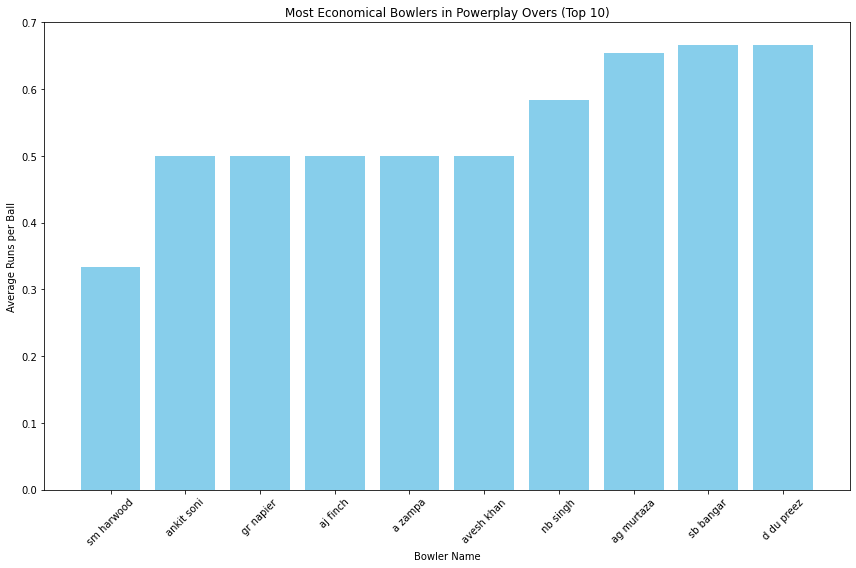

In [0]:
# Assuming 'economical_bowlers_powerplay' is already executed and available as a Spark DataFrame
economical_bowlers_pd = economical_bowlers_powerplay.toPandas()

# Visualizing using Matplotlib
plt.figure(figsize=(12, 8))
# Limiting to top 10 for clarity in the plot
top_economical_bowlers = economical_bowlers_pd.nsmallest(10, 'avg_runs_per_ball')
plt.bar(top_economical_bowlers['player_name'], top_economical_bowlers['avg_runs_per_ball'], color='skyblue')
plt.xlabel('Bowler Name')
plt.ylabel('Average Runs per Ball')
plt.title('Most Economical Bowlers in Powerplay Overs (Top 10)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

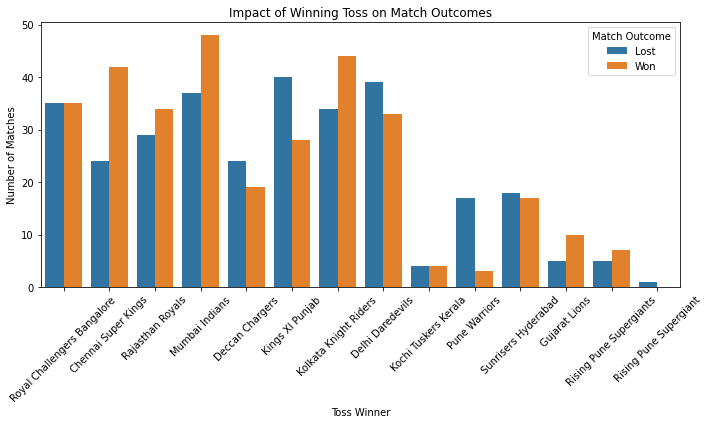

In [0]:
toss_impact_pd = toss_impact_individual_matches.toPandas()

# Creating a countplot to show win/loss after winning toss
plt.figure(figsize=(10, 6))
sns.countplot(x='toss_winner', hue='match_outcome', data=toss_impact_pd)
plt.title('Impact of Winning Toss on Match Outcomes')
plt.xlabel('Toss Winner')
plt.ylabel('Number of Matches')
plt.legend(title='Match Outcome')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/databricks/spark/python/pyspark/sql/pandas/utils.py:124: UserWarning: The conversion of DecimalType columns is inefficient and may take a long time. Column names: [win_percentage] If those columns are not necessary, you may consider dropping them or converting to primitive types before the conversion.
  warnings.warn(


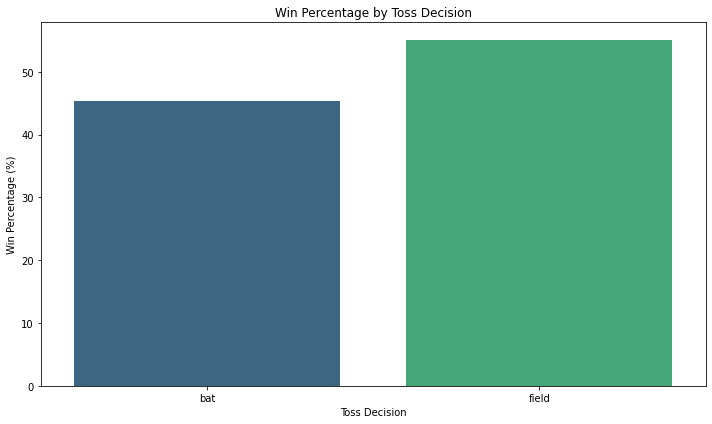

In [0]:
# Run the Spark SQL query and load the result into a pandas DataFrame
impact_toss_decisions = spark.sql("""
SELECT 
    LOWER(toss_name) AS toss_decision,
    COUNT(match_id) AS total_matches,
    SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) AS toss_winner_wins,
    ROUND(100.0 * SUM(CASE WHEN toss_winner = match_winner THEN 1 ELSE 0 END) / COUNT(match_id), 2) AS win_percentage
FROM match
WHERE toss_name IS NOT NULL
  AND LOWER(toss_name) IN ('bat', 'field')
GROUP BY LOWER(toss_name)
ORDER BY toss_decision
""")

toss_impact_pd = impact_toss_decisions.toPandas()

# Creating a bar plot to compare win percentages for each toss decision.
plt.figure(figsize=(10, 6))
sns.barplot(x='toss_decision', y='win_percentage', data=toss_impact_pd, palette='viridis')
plt.title('Win Percentage by Toss Decision')
plt.xlabel('Toss Decision')
plt.ylabel('Win Percentage (%)')
plt.tight_layout()
plt.show()


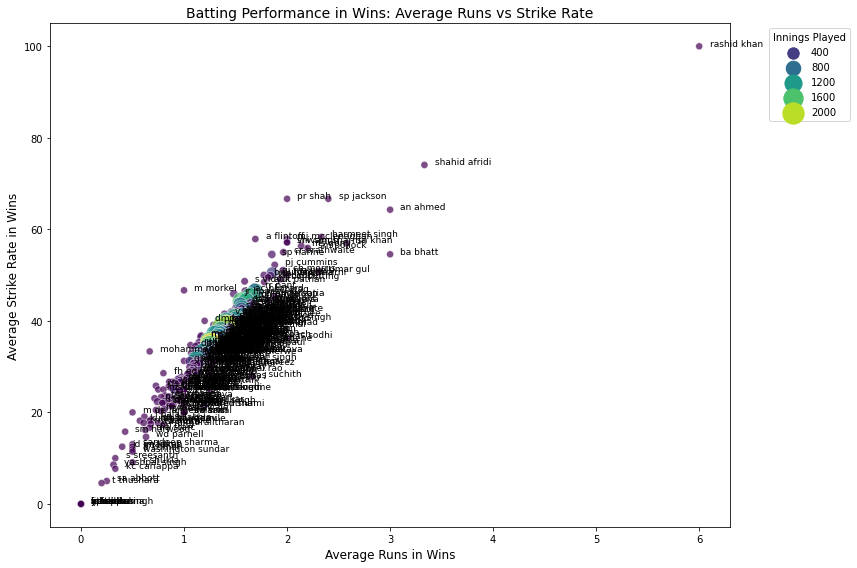

In [0]:
# Run the Spark SQL query and load the result into a pandas DataFrame
average_performance_in_wins = spark.sql("""
SELECT 
    p.player_name,
    AVG(b.runs_scored) AS avg_runs_in_wins,
    AVG(b.ball_id) AS avg_balls_faced_in_wins,
    ROUND(SUM(b.runs_scored) / SUM(b.ball_id) * 100, 2) AS avg_strike_rate_in_wins,
    COUNT(*) AS innings_played
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN player p ON pm.player_id = p.player_id
JOIN match m ON pm.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY p.player_name
ORDER BY avg_strike_rate_in_wins DESC
""")
avg_perf_pd = average_performance_in_wins.toPandas()

# Create a scatter plot to visualize average runs vs average strike rate, 
# with the size of the point reflecting the number of innings played.
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(x='avg_runs_in_wins', 
                          y='avg_strike_rate_in_wins', 
                          size='innings_played',
                          hue='innings_played',
                          data=avg_perf_pd,
                          palette='viridis', 
                          sizes=(50, 500),
                          alpha=0.7)

plt.title('Batting Performance in Wins: Average Runs vs Strike Rate', fontsize=14)
plt.xlabel('Average Runs in Wins', fontsize=12)
plt.ylabel('Average Strike Rate in Wins', fontsize=12)

# Optionally, annotate some points with the player name for better insight
for index, row in avg_perf_pd.iterrows():
    plt.text(row['avg_runs_in_wins'] + 0.1, row['avg_strike_rate_in_wins'] + 0.1, 
             row['player_name'], fontsize=9)

plt.legend(title='Innings Played', bbox_to_anchor=(1.05, 1), loc=2)
plt.tight_layout()
plt.show()


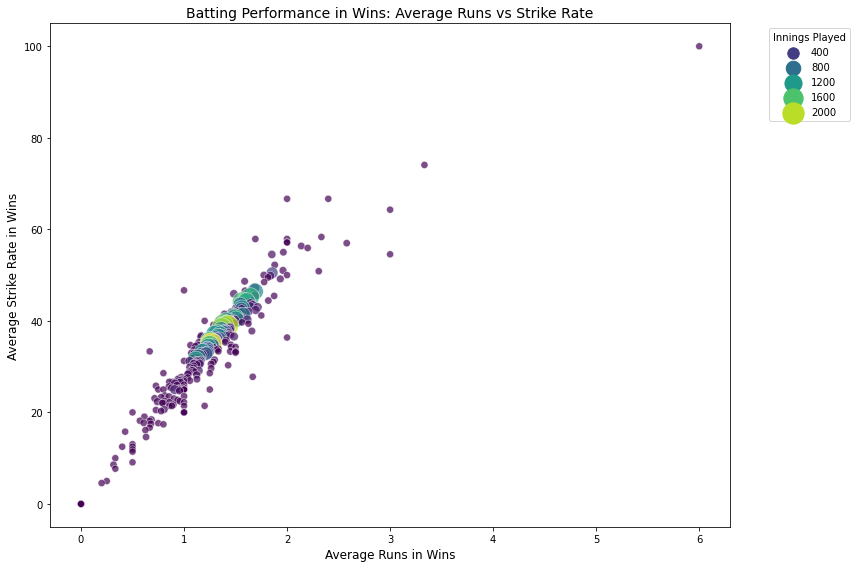

In [0]:
# Assuming you have already run the SQL query and gotten the result in Spark
average_performance_in_wins = spark.sql("""
SELECT 
    p.player_name,
    AVG(b.runs_scored) AS avg_runs_in_wins,
    AVG(b.ball_id) AS avg_balls_faced_in_wins,
    ROUND(SUM(b.runs_scored) / SUM(b.ball_id) * 100, 2) AS avg_strike_rate_in_wins,
    COUNT(*) AS innings_played
FROM ball_by_ball b
JOIN player_match pm ON b.match_id = pm.match_id AND b.striker = pm.player_id
JOIN player p ON pm.player_id = p.player_id
JOIN match m ON pm.match_id = m.match_id
WHERE m.match_winner = pm.player_team
GROUP BY p.player_name
ORDER BY avg_strike_rate_in_wins DESC
""")

# Convert the Spark DataFrame to pandas DataFrame
avg_perf_pd = average_performance_in_wins.toPandas()

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming avg_perf_pd is already created from the Spark SQL query and converted to a Pandas DataFrame

plt.figure(figsize=(12, 8))

# Create a bubble chart
scatter = sns.scatterplot(
    x='avg_runs_in_wins', 
    y='avg_strike_rate_in_wins', 
    size='innings_played',
    hue='innings_played',  # Using innings played for color distinction
    data=avg_perf_pd,
    palette='viridis',
    sizes=(50, 500),  # Adjust the size range to make it clearer
    alpha=0.7
)

# Title and labels
plt.title('Batting Performance in Wins: Average Runs vs Strike Rate', fontsize=14)
plt.xlabel('Average Runs in Wins', fontsize=12)
plt.ylabel('Average Strike Rate in Wins', fontsize=12)

# Legend adjustments
plt.legend(title='Innings Played', bbox_to_anchor=(1.05, 1), loc=2)

# Tight layout for better fitting
plt.tight_layout()

plt.show()
